# Market Risk Limits Analysis

This notebook provides a comprehensive framework for setting and monitoring position limits across perpetual markets. It calculates appropriate risk limits based on liquidity depth, volatility, and market microstructure.

## Executive Summary

Position limits are critical for maintaining market stability and preventing cascading liquidations. This analysis:
- Calculates maximum safe position sizes based on available liquidity
- Adjusts limits for market volatility and trading conditions
- Provides tiered risk limits for different market participants
- Monitors limit utilization in real-time

In [1]:
# Essential imports only
import sys
sys.path.append('../src')

from risk_model.notebook_helpers import (
    fetch_market_data, calculate_risk_metrics_all,
    calculate_dynamic_limits, generate_utilization_data
)
from risk_model.chart_config import setup_chart_style, COLORS, format_axis_labels
from risk_model.scenario_config import PARTICIPANT_TIERS, ALERT_THRESHOLDS
from risk_model.metrics import (
    calculate_position_limits, calculate_max_oi, 
    RISK_TO_MAX_OI, IMPACT_TO_MAX_POSITION
)
from risk_model.plotting import plot_risk_limits_comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

setup_chart_style()

## 1. Risk Limit Methodology

### Position Limit Framework

Our position limit methodology considers three key factors:

1. **Liquidity Depth**: How much can be traded without excessive price impact
2. **Market Volatility**: Higher volatility requires more conservative limits
3. **Concentration Risk**: Single positions shouldn't dominate market open interest

### Limit Calculation Formula

The maximum position size is calculated as:

```
Position Limit = MIN(
    Liquidity-Based Limit,
    Volatility-Adjusted Limit,
    Concentration Limit
)
```

Where each component provides a safety constraint based on different risk factors.

In [2]:
# Fetch current market data
from risk_model.config import load_markets_config
markets_config = load_markets_config()
markets = markets_config['markets']
market_data = fetch_market_data(markets, lookback_days=30, limit_markets=10)

/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()


/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()


/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()


/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()


Failed to fetch data for MATIC-PERP: 'bids'


## 2. Current Market Risk Limits

The table below shows calculated position limits for each market based on current conditions. These limits represent the maximum safe position size that can be established without causing significant market disruption.

In [3]:
# Calculate risk metrics and position limits
risk_metrics = calculate_risk_metrics_all(market_data)

# Display key limit parameters
limit_summary = risk_metrics[[
    'market', 'risk_score', 'max_oi_mm', 'position_limit_mm', 
    'liquidity_1pct_mm', 'realized_vol_30d'
]].copy()

limit_summary.columns = [
    'Market', 'Risk Score', 'Max OI ($MM)', 'Position Limit ($MM)', 
    'Liquidity @1% ($MM)', 'Volatility (30d)'
]

print("\n📊 Current Position Limits by Market:")
display(limit_summary.round(2))


📊 Current Position Limits by Market:


,Market,Risk Score,Max OI ($MM),Position Limit ($MM),Liquidity @1% ($MM),Volatility (30d)
0,ETH-PERP,3,3.95,0.59,1.58,0.78
1,BTC-PERP,3,2.04,0.31,0.82,0.53
2,SOL-PERP,3,6.07,0.91,2.43,0.84
3,ARB-PERP,4,0.19,0.03,0.13,1.00


## 3. Tiered Risk Limits

Different market participants have varying risk tolerances and capital requirements. We implement a tiered system that provides appropriate limits for each participant type:

- **Retail Traders**: Conservative limits to protect individual traders
- **Professional Traders**: Moderate limits with proven risk management
- **Market Makers**: Higher limits to provide liquidity
- **Institutional**: Maximum limits for sophisticated participants

In [4]:
# Calculate tiered limits for top markets using configured tiers
top_markets = risk_metrics.nsmallest(5, 'risk_score')
tiered_limits = pd.DataFrame()

for tier, multiplier in PARTICIPANT_TIERS.items():
    tier_data = top_markets[['market', 'position_limit_mm']].copy()
    tier_data['tier'] = tier
    tier_data['limit'] = tier_data['position_limit_mm'] * multiplier
    tiered_limits = pd.concat([tiered_limits, tier_data])

# Pivot for display
limits_pivot = tiered_limits.pivot(index='market', columns='tier', values='limit')
limits_pivot = limits_pivot[list(PARTICIPANT_TIERS.keys())]

print("\n🎯 Tiered Position Limits ($MM):")
display(limits_pivot.round(2))


🎯 Tiered Position Limits ($MM):


tier,Retail,Professional,Market Maker,Institutional
market,,,,
ARB-PERP,0.00,0.01,0.01,0.03
BTC-PERP,0.02,0.06,0.15,0.31
ETH-PERP,0.03,0.12,0.30,0.59
SOL-PERP,0.05,0.18,0.46,0.91


## 4. Risk-Based Limit Visualization

The following visualizations show how position limits vary based on market risk characteristics. Markets with better liquidity and lower volatility can support larger positions safely.

/Users/msmart/clob-risk-modelling/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/plotting.py:599: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1600x1000 with 6 Axes>,
 (<Axes: title={'center': 'Risk Score vs Position Limits'}, xlabel='Risk Score (1-5)', ylabel='Position Limit ($MM)'>,
  <Axes: title={'center': 'Liquidity vs Maximum OI'}, xlabel='Liquidity @1% Impact ($MM)', ylabel='Max Open Interest ($MM)'>,
  <Axes: title={'center': 'Position Limits by Market'}, xlabel='Position Limit ($MM)'>,
  <Axes: title={'center': 'Risk Component Breakdown'}, xlabel='Market'>))

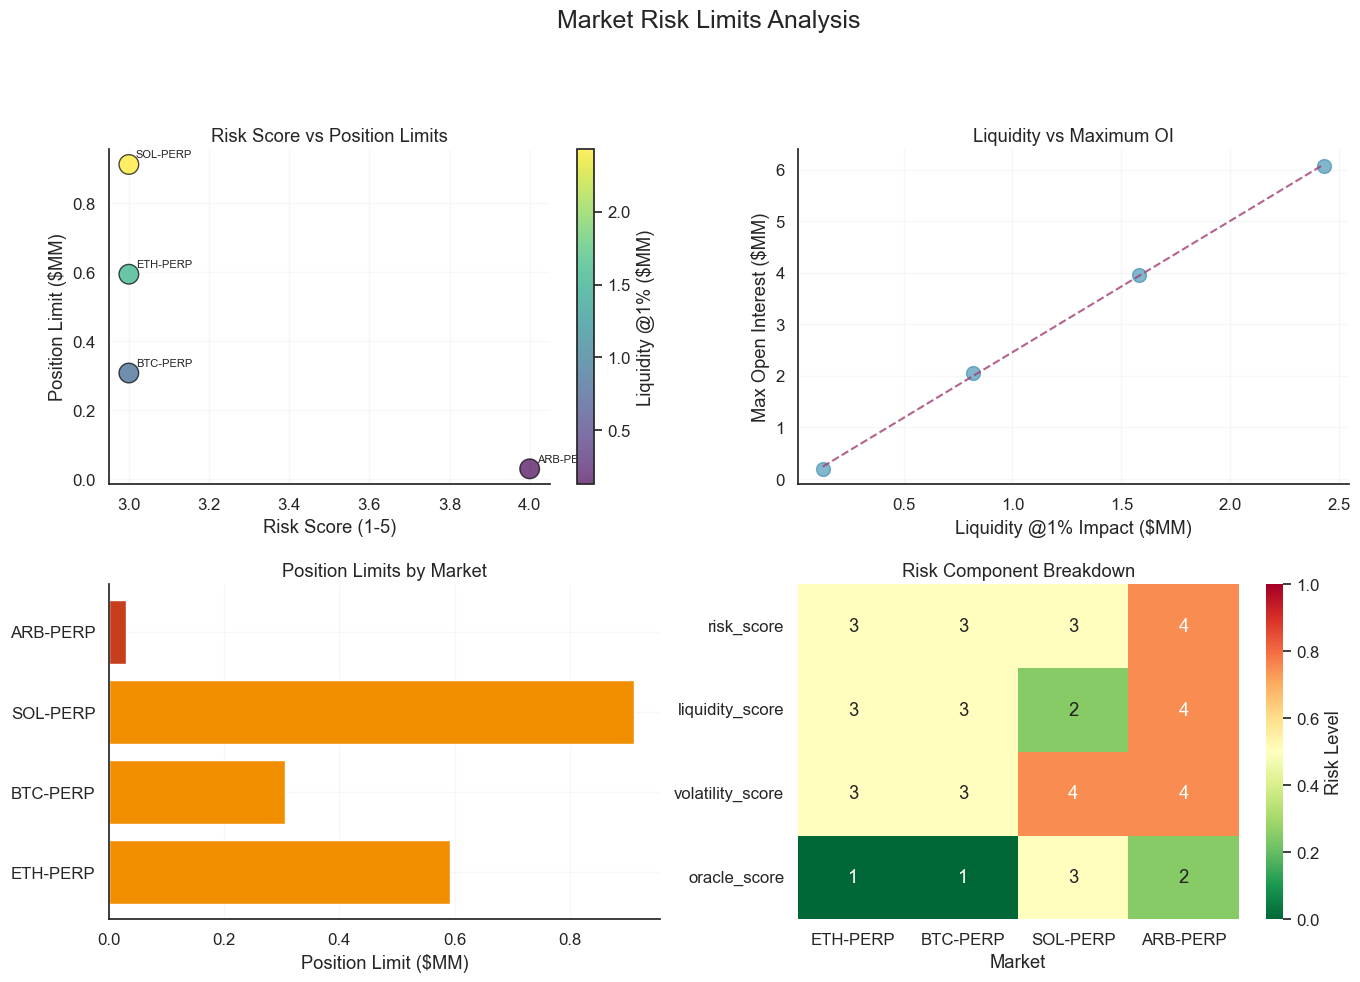

In [5]:
# Visualize risk limits
plot_risk_limits_comparison(risk_metrics)

## 5. Dynamic Limit Adjustments

Position limits should adapt to changing market conditions. We implement dynamic adjustments based on:

### Volatility Scaling
During high volatility periods, limits are reduced to account for increased liquidation risk:
- Normal volatility (< 50% annualized): 100% of base limit
- Elevated volatility (50-100%): 75% of base limit  
- High volatility (> 100%): 50% of base limit

### Liquidity Conditions
Limits scale with available market depth:
- Deep liquidity (> $10MM @ 1%): 100% of base limit
- Moderate liquidity ($5-10MM): 75% of base limit
- Thin liquidity (< $5MM): 50% of base limit

In [6]:
# Calculate dynamic adjustments using helper function
adjusted_limits = calculate_dynamic_limits(risk_metrics)

# Show adjustments for volatile markets
volatile_markets = adjusted_limits[
    (adjusted_limits['total_adjustment'] < 1.0)
][['market', 'position_limit_mm', 'adjusted_limit', 'vol_adjustment', 'liq_adjustment']]

print("\n⚠️  Dynamic Limit Adjustments for Stressed Markets:")
if len(volatile_markets) > 0:
    display(volatile_markets.round(2))
else:
    print("All markets operating under normal conditions")


⚠️  Dynamic Limit Adjustments for Stressed Markets:


,market,position_limit_mm,adjusted_limit,vol_adjustment,liq_adjustment
0,ETH-PERP,0.59,0.22,0.75,0.5
1,BTC-PERP,0.31,0.11,0.75,0.5
2,SOL-PERP,0.91,0.34,0.75,0.5
3,ARB-PERP,0.03,0.01,0.75,0.5


## 6. Limit Monitoring Dashboard

Real-time monitoring of position limit utilization helps identify potential risks before they materialize. The dashboard below shows current utilization levels and alerts for markets approaching their limits.

In [7]:
# Generate utilization data using helper function
utilization_data = generate_utilization_data(adjusted_limits, simulate=True)

print("\n📈 Current Position Limit Utilization:")
display(utilization_data[['market', 'adjusted_limit', 'current_oi', 'utilization_pct', 'alert_level']].round(2).head(10))


📈 Current Position Limit Utilization:


,market,adjusted_limit,current_oi,utilization_pct,alert_level
2,SOL-PERP,0.34,0.14,41.60,Normal
0,ETH-PERP,0.22,0.08,35.37,Normal
1,BTC-PERP,0.11,0.03,24.86,Normal
3,ARB-PERP,0.01,0.00,16.00,Normal


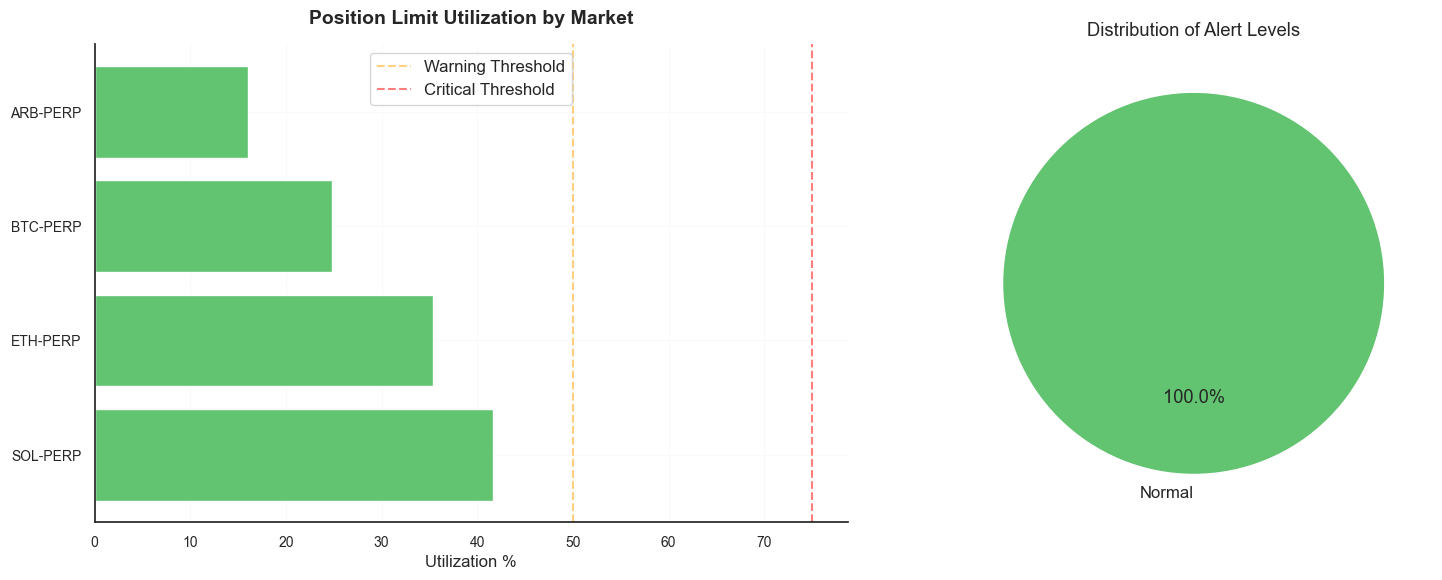

In [8]:
# Visualize utilization levels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Utilization bar chart
top_utilized = utilization_data.head(10)
colors = [
    COLORS['success'] if x == 'Normal' else 
    COLORS['warning'] if x == 'Warning' else 
    COLORS['danger'] for x in top_utilized['alert_level']
]

bars = ax1.barh(top_utilized['market'], top_utilized['utilization_pct'], color=colors)
ax1.axvline(x=ALERT_THRESHOLDS['utilization']['warning'], color='orange', linestyle='--', alpha=0.5, label='Warning Threshold')
ax1.axvline(x=ALERT_THRESHOLDS['utilization']['critical'], color='red', linestyle='--', alpha=0.5, label='Critical Threshold')
format_axis_labels(ax1, xlabel='Utilization %', title='Position Limit Utilization by Market')
ax1.legend()

# Alert distribution
alert_counts = utilization_data['alert_level'].value_counts()
colors_pie = [COLORS['success'], COLORS['warning'], COLORS['danger'], COLORS['dark']]
ax2.pie(alert_counts.values, labels=alert_counts.index, colors=colors_pie[:len(alert_counts)], 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Alert Levels')

plt.tight_layout()
plt.show()

## 7. Recommendations and Next Steps

Based on the current analysis, we recommend:

### Immediate Actions
1. **Review High Utilization Markets**: Markets with >75% utilization require immediate attention
2. **Adjust Volatile Market Limits**: Apply dynamic reductions for markets with elevated volatility
3. **Monitor Liquidity Changes**: Track depth metrics for early warning of deteriorating conditions

### Medium-Term Improvements  
1. **Implement Real-Time Monitoring**: Connect to live position data for continuous tracking
2. **Automate Limit Adjustments**: Deploy smart contracts for dynamic limit enforcement
3. **Enhance Risk Scoring**: Incorporate additional factors like funding rates and basis

### Long-Term Strategy
1. **Cross-Market Risk Management**: Consider correlations between markets for portfolio limits
2. **Machine Learning Models**: Develop predictive models for limit optimization
3. **Regulatory Alignment**: Ensure limits meet evolving compliance requirements

In [9]:
# Export limit configuration
limit_config = {
    'timestamp': pd.Timestamp.now().isoformat(),
    'limits': adjusted_limits[['market', 'adjusted_limit', 'risk_score']].to_dict('records'),
    'tiers': PARTICIPANT_TIERS,
    'risk_mapping': RISK_TO_MAX_OI,
    'impact_mapping': IMPACT_TO_MAX_POSITION
}

print("\n✅ Risk limit configuration ready for export")
print(f"Total markets configured: {len(adjusted_limits)}")
print(f"Markets requiring immediate attention: {len(utilization_data[utilization_data['alert_level'] != 'Normal'])}")


✅ Risk limit configuration ready for export
Total markets configured: 4
Markets requiring immediate attention: 0
